In [13]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import powerlaw as pl
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
# add parent directory
sys.path.append('..\\..')
from src.utils import *

In [14]:
# show current databases in data folder
cwd = os.getcwd()
analysis_path = os.path.abspath(os.path.join(cwd, os.pardir))
parent_path = os.path.abspath(os.path.join(analysis_path, os.pardir))
figure_path = f"{cwd}\\figures\\stylised_facts"
data_path = f"{parent_path}\\data"
databases = os.listdir(data_path)
print(f"databases = {databases}")

databases = ['growth.db', 'growth2.db', 'nogrowth.db', 'nogrowth2.db']


In [15]:
# change matplotlib font to serif
plt.rcParams['font.family'] = ['serif']
# figure size
x_figsize = 10
y_figsize = x_figsize/2
# large fontsize
large = 18
# small fontsize
small = 14
# load model parameters
params = load_parameters(f'{parent_path}\\src\\parameters.yml')
# analysis parameters
steps = params['simulation']['steps']
start = params['simulation']['start']*steps
end = (params['simulation']['start'] + params['simulation']['years'])*steps
middle = int(end/2)
years = np.linspace(0, params['simulation']['years'], params['simulation']['years']*steps)

In [16]:
# connect to sql database
# database index
index = 0
# get database name
database_name = databases[index]
# create connection to database
con = sqlite3.connect(f"{data_path}\\{database_name}")
# create database cursor
cur = con.cursor()

In [17]:
# macro_results table 
# np.random.seed(0)
sim = 0
macro = pd.read_sql_query(
    f"""
    SELECT * FROM macro_data
    WHERE simulation = {sim}
    ;
    """,
    con
)
macro

,simulation,time,consumption,nominal_consumption,investment,nominal_investment,real_gdp,nominal_gdp,capital,cfirm_productivity,...,bank_nhhi,bank_hpi,avg_loan_interest,avg_reserve_ratio,avg_capital_ratio,money_supply,bank_bankruptcy,bank_mean_degree,cfirm_mean_degree,kfirm_mean_degree
0,0,1,1594.519584,1614.654854,402.850562,407.166861,1997.370146,2021.821715,5082.850562,1.004955,...,0.007500,1.000000,0.019749,0.549029,0.063727,3.929846e+03,0.0,20.0,1.035,0.00
1,0,2,1436.752627,1455.683059,404.521277,415.123475,1841.273904,1870.806534,5360.300575,1.008575,...,0.007505,1.000000,0.019540,0.555534,0.067477,3.881785e+03,0.0,20.7,1.165,0.00
2,0,3,1448.532262,1469.398311,486.690631,505.736760,1935.222893,1975.135071,5712.305186,1.013468,...,0.007672,1.000000,0.019322,0.560249,0.071069,3.844713e+03,0.0,22.9,1.385,0.00
3,0,4,1459.711035,1483.955890,534.055474,561.748667,1993.766510,2045.704557,6099.917542,1.020236,...,0.008790,1.000000,0.019109,0.559618,0.073563,3.845919e+03,0.0,27.0,1.625,0.00
4,0,5,1448.675184,1476.984893,557.263895,591.905738,2005.939078,2068.890630,6494.323711,1.024973,...,0.009774,0.035885,0.018894,0.559584,0.075861,3.854338e+03,0.0,32.2,1.930,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0,596,40914.533854,547749.596356,8806.601428,78661.401408,49721.135281,626410.997763,345932.666454,25.031435,...,0.097912,0.139128,0.013545,0.623758,0.359778,1.841219e+06,0.0,124.2,6.025,0.94
596,0,597,41153.590409,553379.733449,8648.284183,77825.934639,49801.874592,631205.668088,345858.311233,25.229024,...,0.100074,0.134446,0.013552,0.618139,0.376778,1.867303e+06,0.0,123.2,6.015,0.94
597,0,598,41363.722742,558289.249204,8833.851640,80178.056776,50197.574382,638467.305980,344875.911448,25.377960,...,0.100504,0.149457,0.013547,0.618246,0.396856,1.876885e+06,0.0,124.8,5.990,0.94
598,0,599,41655.597003,564098.452194,8508.264296,77299.276097,50163.861300,641397.728291,345684.426812,25.487764,...,0.103044,0.144768,0.013511,0.614774,0.413165,1.890145e+06,0.0,124.4,6.040,0.96


In [18]:
# new time series
# real gdp growth 
macro['rgdp_growth'] = np.log(macro['real_gdp']) - np.log(macro['real_gdp'].shift(steps))
# inflation
macro['inflation'] = np.log(macro['cfirm_price_index']) - np.log(macro['cfirm_price_index'].shift(steps))
# wage inflation
macro['wage_inflation'] = np.log(macro['avg_wage']) - np.log(macro['avg_wage'].shift(steps))
# debt ratio
macro['debt_ratio'] = macro['debt']/macro['nominal_gdp']
# wage share
macro['wage_share'] = macro['wages']/macro['nominal_gdp']
# profit share
macro['profit_share'] = macro['profits']/macro['nominal_gdp']
# normalised productivity to start date
macro['productivity'] = (macro['real_gdp']/macro['employment'])/(macro['real_gdp'][start]/macro['employment'][start])
# productivity growth
macro['productivity_growth'] = np.log(macro['productivity']) - np.log(macro['productivity'].shift(steps))
# credit: debt growth rate
macro['credit'] = np.log(macro['debt']) - np.log(macro['debt'].shift(steps))
# change unemployment 
macro['change_unemployment'] = macro['unemployment_rate'] - macro['unemployment_rate'].shift(steps)
# economic crises
crises = pd.Series(np.where(macro['rgdp_growth'] < 0, 1, 0))
macro['crises'] = np.where((crises.shift(-1) == 0) & (crises == 1) & (crises.shift(1) == 0), 0, crises)
# drop transient data
macro = macro.loc[macro['time'] > start]
# reset index
macro.reset_index(inplace=True, drop=True)
macro

,simulation,time,consumption,nominal_consumption,investment,nominal_investment,real_gdp,nominal_gdp,capital,cfirm_productivity,...,inflation,wage_inflation,debt_ratio,wage_share,profit_share,productivity,productivity_growth,credit,change_unemployment,crises
0,0,201,4293.917894,10583.142723,1314.858174,2105.584954,5608.776068,12688.727677,46330.514713,2.825843,...,0.020430,0.041152,0.988593,0.767769,0.149642,1.000000,0.013003,0.209084,-0.0020,0
1,0,202,4397.658086,10889.098344,1227.853276,1959.440103,5625.511362,12848.538447,46457.262707,2.838898,...,0.019849,0.040622,1.012134,0.768162,0.148272,0.999292,0.011920,0.186324,-0.0375,0
2,0,203,4488.891746,11176.759228,1216.649532,1946.282172,5705.541278,13123.041400,46525.841847,2.854415,...,0.020146,0.041126,1.036816,0.767144,0.145537,1.004007,0.009882,0.190662,-0.0220,0
3,0,204,4567.641968,11435.017676,1187.389716,1896.137232,5755.031685,13331.154908,46691.149833,2.875675,...,0.020142,0.040480,1.054817,0.765250,0.163246,1.009561,0.014062,0.180905,-0.0215,0
4,0,205,4618.534250,11623.905915,1228.077831,1982.632488,5846.612080,13606.538403,46766.689886,2.895240,...,0.020924,0.041015,1.078350,0.765246,0.145544,1.016130,0.016001,0.156740,-0.0245,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0,596,40914.533854,547749.596356,8806.601428,78661.401408,49721.135281,626410.997763,345932.666454,25.031435,...,0.018806,0.038008,1.336078,0.776973,0.118246,8.553437,0.021315,0.063248,0.0025,0
396,0,597,41153.590409,553379.733449,8648.284183,77825.934639,49801.874592,631205.668088,345858.311233,25.229024,...,0.018567,0.039431,1.368111,0.777061,0.110778,8.597971,0.023178,0.082492,-0.0060,0
397,0,598,41363.722742,558289.249204,8833.851640,80178.056776,50197.574382,638467.305980,344875.911448,25.377960,...,0.016934,0.040881,1.354226,0.776690,0.099675,8.661860,0.023554,0.064517,0.0040,0
398,0,599,41655.597003,564098.452194,8508.264296,77299.276097,50163.861300,641397.728291,345684.426812,25.487764,...,0.015230,0.038824,1.368809,0.776236,0.122494,8.700478,0.021632,0.074410,0.0095,0


In [19]:
num_crises = np.where((macro['rgdp_growth'] < 0) & (macro['rgdp_growth'].shift(1) < 0) & (macro['rgdp_growth'].shift(2) > 0), 1, 0).sum()
num_crises

10

In [20]:
# functions to be used

# log scale y ticks 
def logscale_ticks(low: float, high: float, num: int) -> np.ndarray:
    """
    Get ticks for either x or y axis from data, rounded to first digit spaced by num in log 10.
    
    Parameters
    ----------
        series : pd.Series
            time series
            
        num : int 
            number of ticks to return
    
    Returns
    -------
        ticks : numpy array
            axis ticks spaced by num in log 10
    """
    log_arr = np.logspace(np.log10(low),np.log10(high), num)
    lengths = np.vectorize(len)(np.char.mod('%d', log_arr))
    factor = 10 ** (lengths - 1)
    round_log_arr = np.int64(np.round(log_arr.astype(int) / factor) * factor)
    return round_log_arr

def plot_autocorrelation(data, figsize: tuple, fontsize: int, savefig: str, lags: int, lamda: int=1600) -> None:
    """
    Plots the autocorrelation function for a given series for a given number of lags.
    
    Parameters
    ----------
        data : series like
            time series
        
        figsize : tuple (int, int) 
            size of figure (x-axis, y-axis)
            
        fontsize : int
            fontsize of legend and ticks
            
        savefig : str
            path and figure name 
        
        lags: int
            number of autocorrelation lags
        
        lamda : int (default = 1600)
            HP lambda parameter (quarterly => lambda=1600)
    """
    # Hodrick-Prescot filter
    cycle, trend = sm.tsa.filters.hpfilter(data, lamda)
    # figure
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    # autocorrelation plot
    tsaplots.plot_acf(cycle, lags=lags, ax=ax1, color='k', vlines_kwargs={"colors": 'k'})
    # change shaded colour
    for item in ax1.collections:
        if type(item)==PolyCollection:
            item.set_facecolor('k')
    # ticks
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # remove title
    plt.title("")
    # save figure
    plt.savefig(savefig, bbox_inches='tight')
    plt.show()

def plot_cross_correlation(x, y, figsize: tuple, fontsize: int, savefig: str, lags: int, lamda: int=1600):
    """
    Plots the cross correlation between series x and series y, from lags to -lags lags.
    
    Parameters
    ----------
        x : series like
            time series
            
        y : series like
            time series
        
        figsize : tuple (int, int) 
            size of figure (x-axis, y-axis)
            
        fontsize : int
            fontsize of legend and ticks
            
        savefig : str
            path and figure name 
        
        lags: int
            number of correlation lags
        
        lamda : int (default = 1600)
            HP lambda parameter (quarterly => lambda=1600)
    """
    # Hodrick-Prescot filter
    xcycle, xtrend = sm.tsa.filters.hpfilter(x, lamda)
    ycycle, ytrend = sm.tsa.filters.hpfilter(y, lamda)
    # figure
    plt.figure(figsize=figsize)
    corr = plt.xcorr(xcycle, ycycle, color='k', maxlags=lags)
    plt.scatter(corr[0], corr[1], color='k')
    plt.axhline(0, color="k")
    # ticks
    plt.xticks([-lags, -lags/2, 0, lags/2, lags], fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    # save figure
    plt.savefig(savefig, bbox_inches='tight')
    plt.show()

# plot complementary cumulative distribution function
def plot_ccdf(data, figsize: tuple, fontsize: int, savefig: str, dp: int=0) -> None:
    """
    Plots the complementary cumulative distribution function (CCDF) for a given series 
    and prints the power law exponent, cut-off value, and compares the distribution to a lognormal.
    
    Parameters
    ----------
        data : pd.Series or numpy array
            series to plot CCDF
            
        figsize : tuple (int, int) 
            size of figure (x-axis, y-axis)
            
        fontsize : int
            fontsize of legend and ticks
            
        savefig : str
            path and figure name 
        dp : int 
            power law fit x minimum number decimal points
    """
    # power law fit results 
    results = pl.Fit(data)
    a, m = results.alpha, results.xmin
    # complementary cdf 
    plt.figure(figsize=figsize)
    # x values 
    x = np.sort(data)
    # complementary cdf (ccdf)
    cdf = np.arange(1,len(data)+1)/(len(data))
    ccdf = 1 - cdf
    plt.scatter(x, ccdf, color='skyblue', edgecolors='k', alpha=0.7, s=40, label='CCDF')
    # power law fit
    # => rescale to start fit from cut off
    index = np.where(x == m)[0][0]
    rescale = ccdf[index]
    power_law_fit = np.where(x >= m, np.power((m)/x,a-1)*rescale, np.nan)
    plt.plot(x, power_law_fit, color='limegreen', linewidth=3, label='Power-Law Fit')
    # power law cut off (mF)
    plt.axvline(m, color='k', linestyle='--', label=r'$m$'f' = {round(m, dp)}') # type: ignore
    # lognormal distribution
    estimates = stats.lognorm.fit(data)
    cdf = stats.lognorm.cdf(x, estimates[0], estimates[1], estimates[2])
    plt.plot(x, 1 - cdf, color='r', linestyle='-.', linewidth=2, label='Log-Normal Fit')
    # log-log axis
    plt.loglog()
    # legend
    plt.legend(loc='lower left', fontsize=fontsize)
    # tick size
    plt.yticks(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    # save figure
    plt.savefig(savefig, bbox_inches='tight')
    plt.show()
    print(f'Power law exponent = {a}')
    print(f'Power law minimum = {m}')
    print(f"Distribution compare = {results.distribution_compare('power_law', 'lognormal')}\n")

# Single Simulation

## Autocorrelation

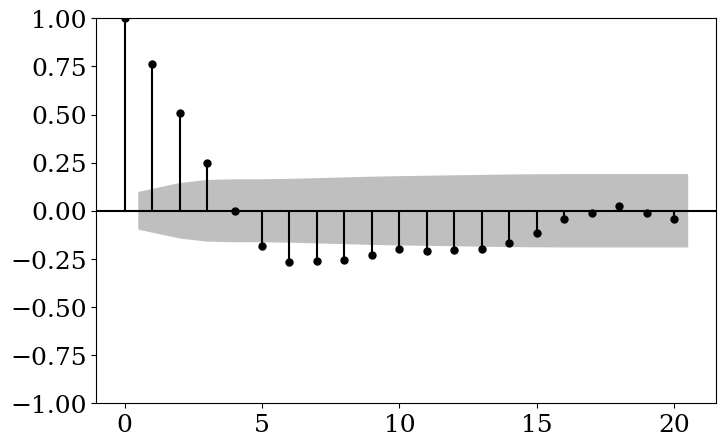

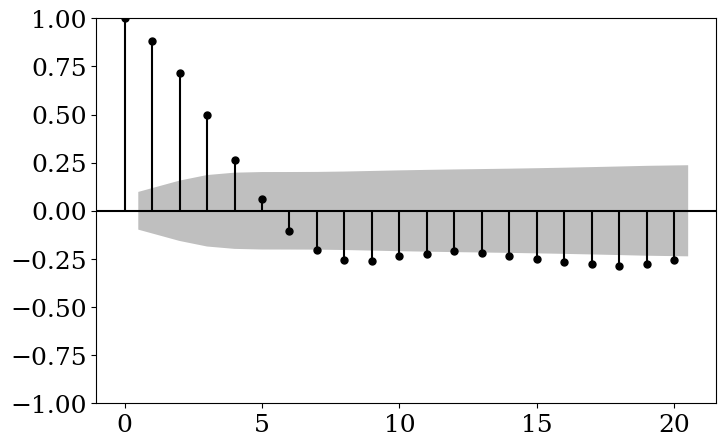

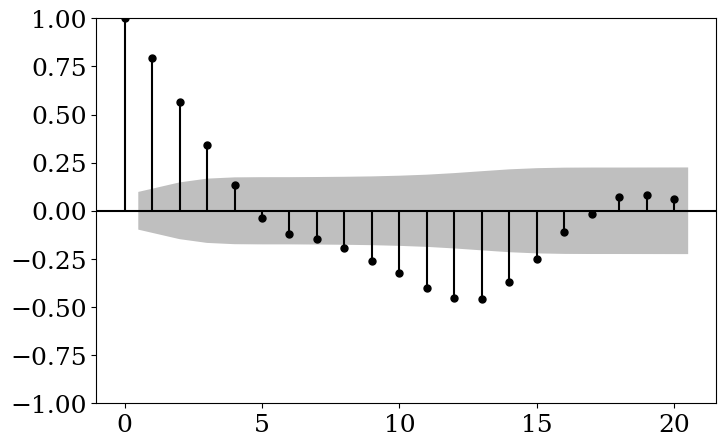

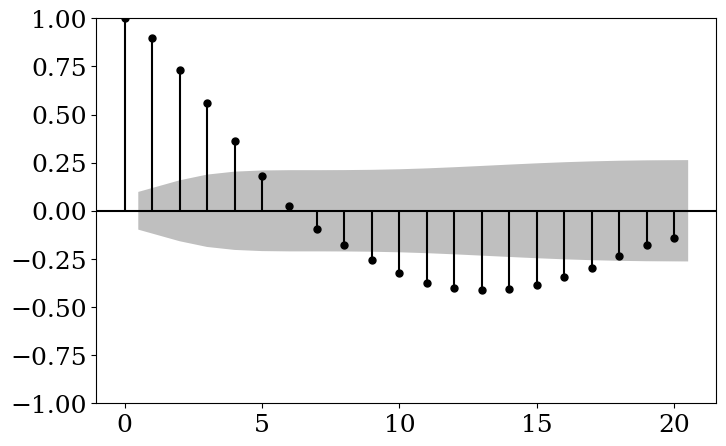

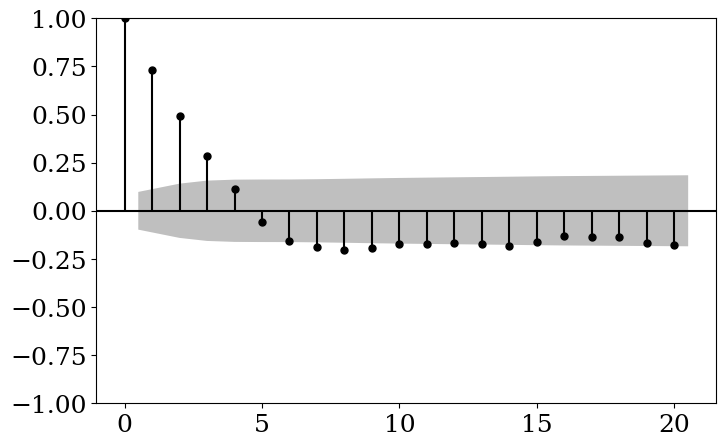

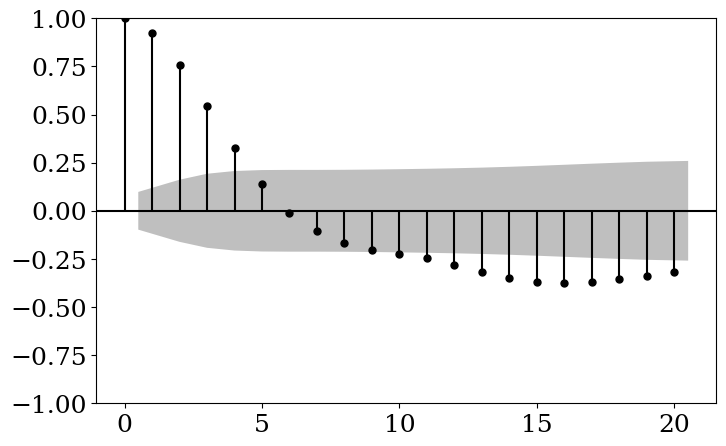

In [21]:
# real gdp autocorrelation
plot_autocorrelation(macro['real_gdp'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_rgdp.png', lags=20, lamda=1600)
# consumption autocorrelation
plot_autocorrelation(macro['consumption'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_consumption.png', lags=20, lamda=1600)
# investment autocorrelation 
plot_autocorrelation(macro['investment'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_investment.png', lags=20, lamda=1600)
# productivity autocorrelation
plot_autocorrelation(macro['productivity'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_productivity.png', lags=20, lamda=1600)
# unemployment rate autocorrelation
plot_autocorrelation(macro['unemployment_rate'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_unemployment.png', lags=20, lamda=1600)
# debt autocorrelation
plot_autocorrelation(macro['debt'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\autocorr_debt.png', lags=20, lamda=1600)

## Cross Correlation

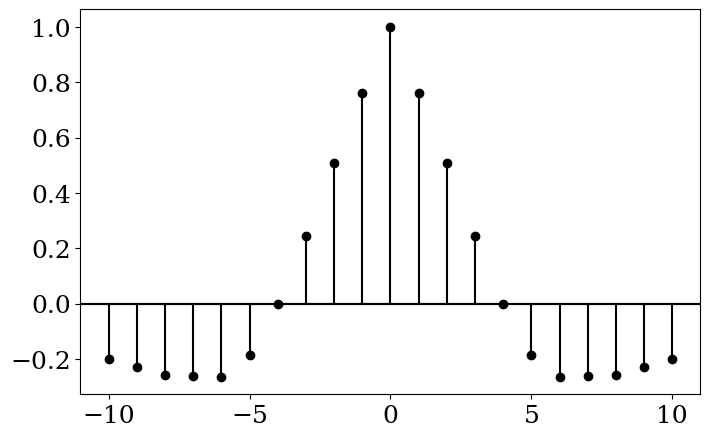

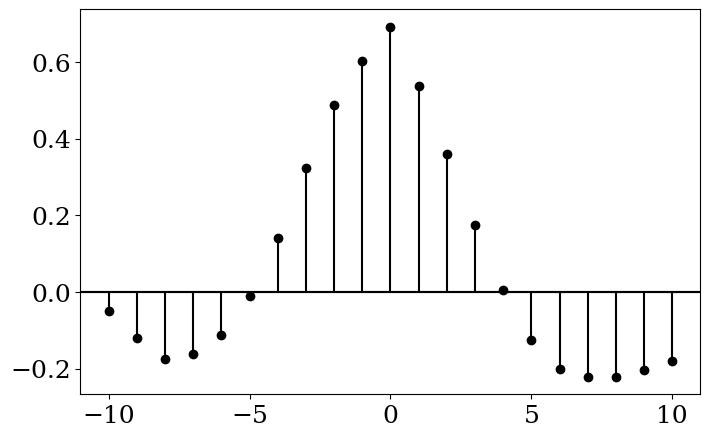

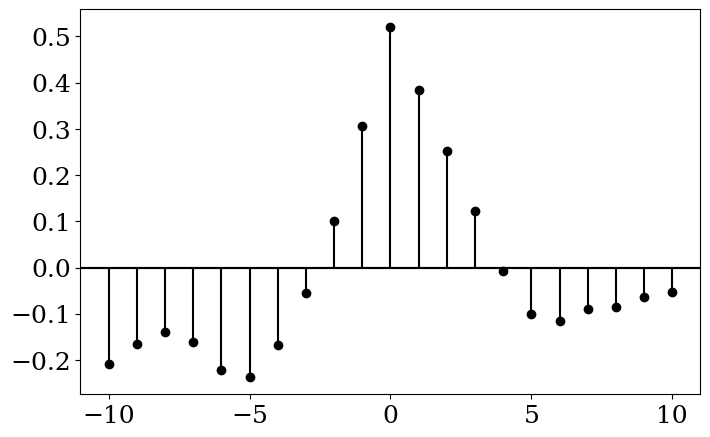

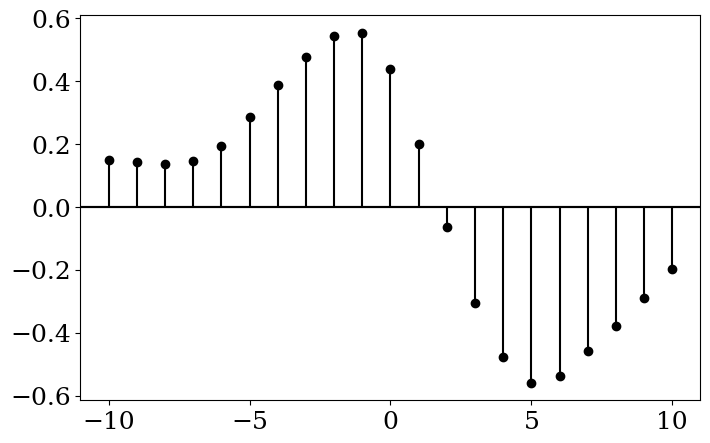

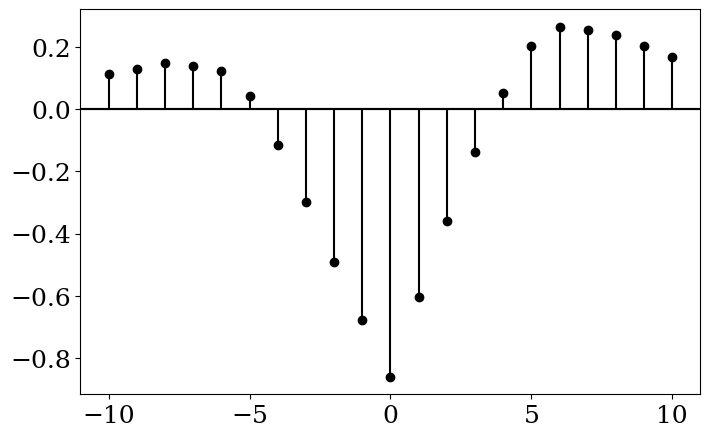

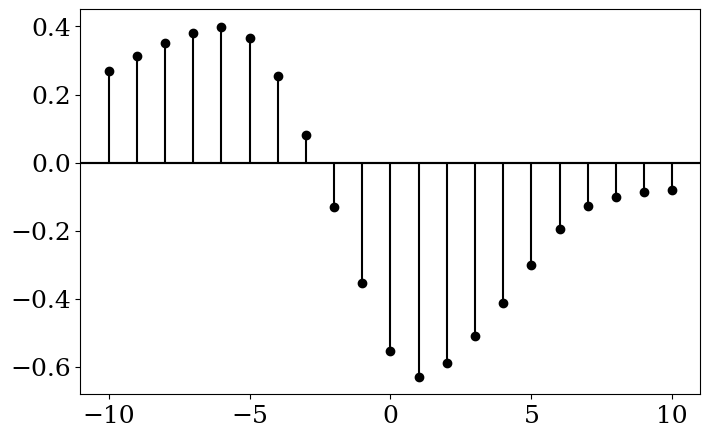

In [22]:
# cross correlation of real gdp with real gdp
plot_cross_correlation(macro['real_gdp'], macro['real_gdp'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_rdgp.png', lags=10, lamda=1600)
# cross correlation of real gdp with consumption
plot_cross_correlation(macro['real_gdp'], macro['consumption'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_consumption.png', lags=10, lamda=1600)
# cross correlation of real gdp with investment
plot_cross_correlation(macro['real_gdp'], macro['investment'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_investment.png', lags=10, lamda=1600)
# cross correlation of real gdp with debt
plot_cross_correlation(macro['real_gdp'], macro['debt'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_debt.png', lags=10, lamda=1600)
# cross correlation of real gdp with unemployment rate
plot_cross_correlation(macro['real_gdp'], macro['unemployment_rate'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_unemployment.png', lags=10, lamda=1600)
# cross correlation of debt with unemployment_rate
plot_cross_correlation(macro['debt'], macro['unemployment_rate'], figsize=(8,5), fontsize=large, savefig=f'{figure_path}\\xcorr_debt_unemployment.png', lags=10, lamda=1600)

## Time Seris

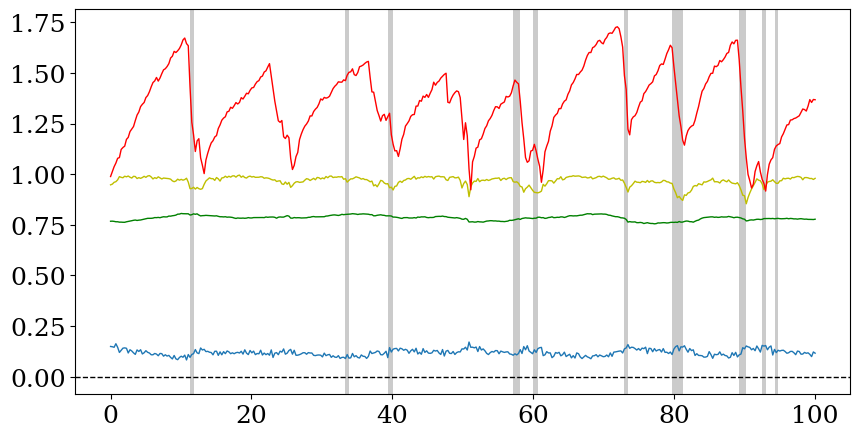

In [23]:
# output shares 
plt.figure(figsize=(x_figsize,y_figsize))
# plot employment rate
plt.plot(years, 1 - macro['unemployment_rate'], color='y', linewidth=1)
# plot debt ratio
plt.plot(years, macro['debt_ratio'], color='r', linewidth=1)
# plot profit share 
plt.plot(years, macro['profit_share'], linewidth=1)
# plot wage share 
plt.plot(years, macro['wage_share'], color='g', linewidth=1)
# plot labour productivity growth rate 
plt.axhline(0, color='k', linestyle='--', linewidth=1)
# crises shaded
for i in macro['crises'].loc[macro['crises']==1][1:].index:
    plt.axvspan(years[i-1], years[i], facecolor='0.2', alpha=0.25)
# ticks
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\time_series_output_shares.png', bbox_inches='tight')
plt.show()

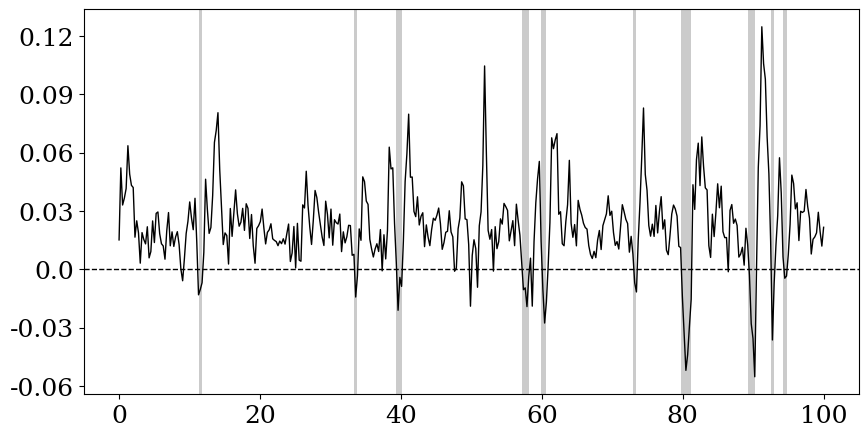

In [24]:
# real gdp growth
plt.figure(figsize=(x_figsize,y_figsize))
# plot 
plt.plot(years, macro['rgdp_growth'], color='k', linewidth=1)
# 0 line
plt.axhline(0, color='k', linestyle='--', linewidth=1)
# crises shaded
for i in macro['crises'].loc[macro['crises']==1][1:].index:
    plt.axvspan(years[i-1], years[i], facecolor='0.2', alpha=0.25)
# ticks
y_sample = np.round(np.linspace(min(macro['rgdp_growth']), max(macro['rgdp_growth']), 7), 2)
plt.yticks(y_sample, y_sample, fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\time_series_rgdp_growth.png', bbox_inches='tight')
plt.show()

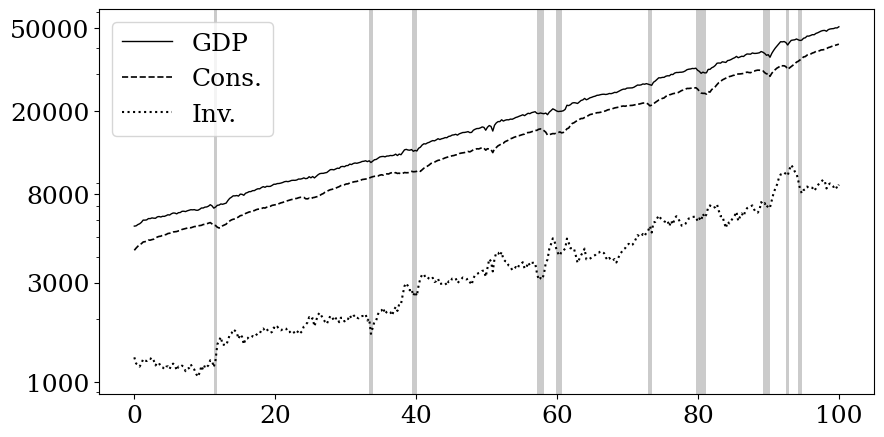

In [25]:
# real GDP and components
plt.figure(figsize=(x_figsize,y_figsize))
# real GDP
plt.plot(years, macro['real_gdp'], color='k', linewidth=1, label='GDP')
# consumption
plt.plot(years, macro['consumption'], color='k', linestyle='--', linewidth=1.2, label='Cons.')
# investment
plt.plot(years, macro['investment'], color='k', linestyle=':', linewidth=1.5, label='Inv.')
# log y axis
plt.yscale('log')
# crises shaded
for i in macro['crises'].loc[macro['crises']==1][1:].index:
    plt.axvspan(years[i-1], years[i], facecolor='0.2', alpha=0.25)
# ticks
y_low = min(macro['investment'].iloc[0], macro['consumption'].iloc[0])
y_high = macro['real_gdp'].iloc[-1]
y_sample = logscale_ticks(y_low, y_high, num=5)
plt.yticks(y_sample, y_sample, fontsize=large)
plt.xticks(fontsize=large)
# legend
plt.legend(loc='upper left', fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\time_series_outputs.png', bbox_inches='tight')
plt.show()

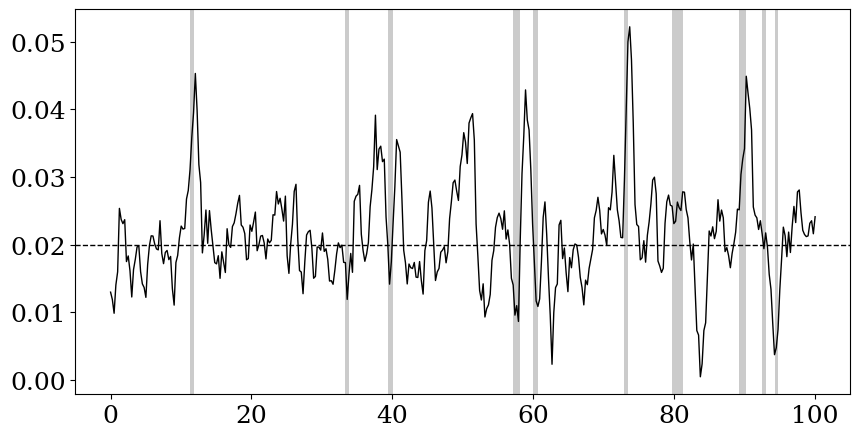

In [26]:
# labour productivity growth
# plot normalised labour productivity
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, macro['productivity_growth'], color='k', linewidth=1)
plt.axhline(0.02, color='k', linestyle='--', linewidth=1)
# crises shaded
for i in macro['crises'].loc[macro['crises']==1][1:].index:
    plt.axvspan(years[i-1], years[i], facecolor='0.2', alpha=0.25)
# ticks
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\time_series_productivity_growth.png', bbox_inches='tight')
plt.show()

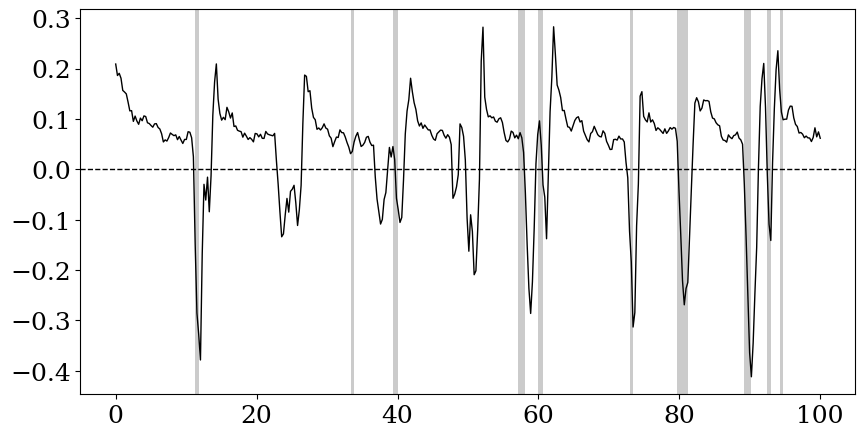

In [27]:
# credit: debt growth rate
# figure
plt.figure(figsize=(x_figsize,y_figsize))
# plot 
plt.plot(years, macro['credit'], color='k', linewidth=1)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
# crises shaded
for i in macro['crises'].loc[macro['crises']==1][1:].index:
    plt.axvspan(years[i-1], years[i], facecolor='0.2', alpha=0.25)
# ticks
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\time_series_credit.png', bbox_inches='tight')
plt.show()

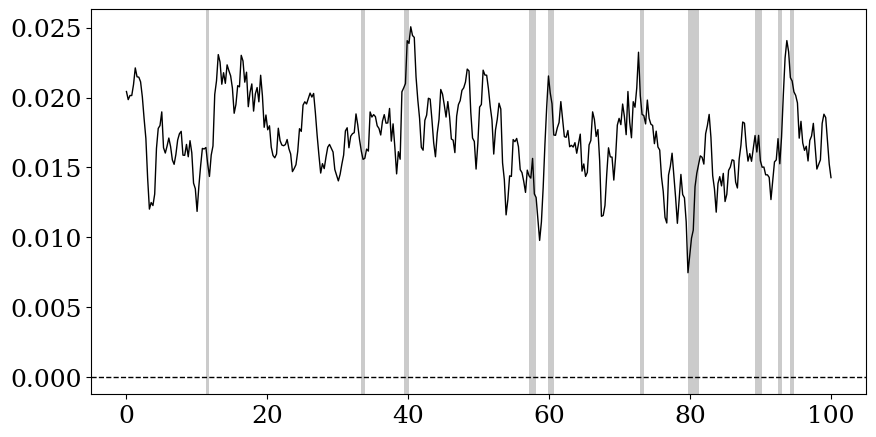

In [28]:
# inflation
# figure
plt.figure(figsize=(x_figsize,y_figsize))
# plot
plt.plot(years, macro['inflation'], color='k', linewidth=1)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
# crises shaded
for i in macro['crises'].loc[macro['crises']==1][1:].index:
    plt.axvspan(years[i-1], years[i], facecolor='0.2', alpha=0.25)
# ticks
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\time_series_inflation.png', bbox_inches='tight')
plt.show()

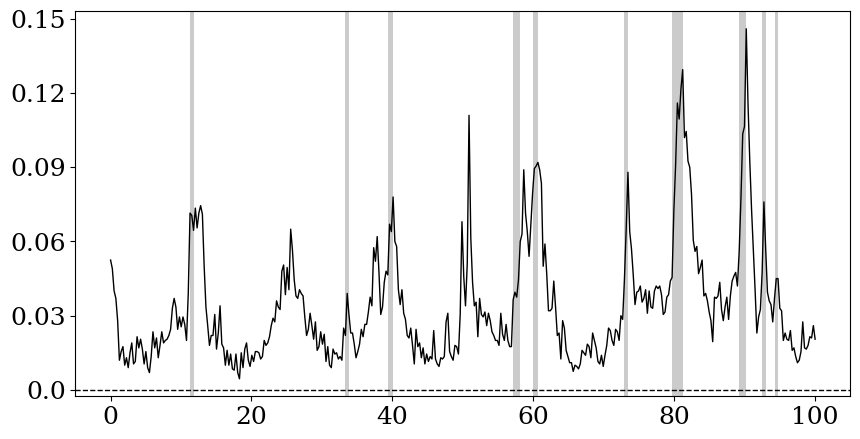

In [29]:
# unemployment rate
plt.figure(figsize=(10,5))
plt.plot(years, macro['unemployment_rate'], color='k', linewidth=1)
plt.axhline(0, color='k', linestyle='--', linewidth=1)
# crises shaded
for i in macro['crises'].loc[macro['crises']==1][1:].index:
    plt.axvspan(years[i-1], years[i], facecolor='0.2', alpha=0.25)
# ticks
y_sample = np.round(np.linspace(min(macro['unemployment_rate']), max(macro['unemployment_rate']), 6), 2)
plt.yticks(y_sample, y_sample, fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\time_series_unemployment.png', bbox_inches='tight')
plt.show()

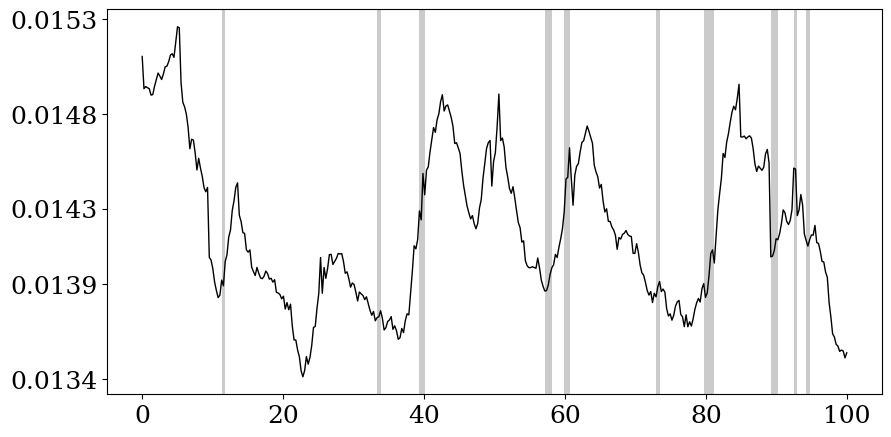

In [30]:
# loan interest
# figure
plt.figure(figsize=(x_figsize,y_figsize))
# plot
plt.plot(years, macro['avg_loan_interest'], color='k', linewidth=1)
# crises shaded
for i in macro['crises'].loc[macro['crises']==1][1:].index:
    plt.axvspan(years[i-1], years[i], facecolor='0.2', alpha=0.25)
# ticks
y_sample = np.round(np.linspace(min(macro['avg_loan_interest']), max(macro['avg_loan_interest']), 5), 4)
plt.yticks(y_sample, y_sample, fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\time_series_interest.png', bbox_inches='tight')
plt.show()

## Economic Relationships

                            OLS Regression Results                            
Dep. Variable:              inflation   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.111
Date:                Tue, 30 Apr 2024   Prob (F-statistic):             0.0785
Time:                        22:43:20   Log-Likelihood:                 1778.2
No. Observations:                 400   AIC:                            -3552.
Df Residuals:                     398   BIC:                            -3544.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0175      0.00

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


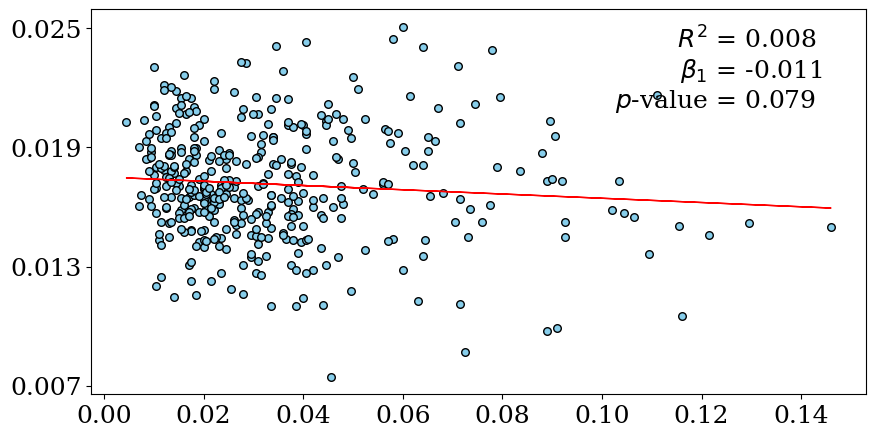

In [31]:
# Phillips Curve: relationship between inflation and unemployment rate
pc_model = sm.OLS(macro['inflation'], sm.add_constant(macro['unemployment_rate']))
pc_results = pc_model.fit()
print(pc_results.summary())
# plot results
plt.figure(figsize=(10,5))
plt.scatter(x=macro['unemployment_rate'], y=macro['inflation'], color='skyblue', s=30, edgecolors='k')
plt.plot(macro['unemployment_rate'], pc_results.params['const'] + pc_results.params['unemployment_rate']*macro['unemployment_rate'], color='r', linewidth=1)
# regression results
plt.text(0.115, 0.024, r'$R^2$ = ' + str(round(pc_results.rsquared, 3)), fontsize=large)
plt.text(0.1157, 0.0225, r'$\beta_1$ = ' + str(round(pc_results.params['unemployment_rate'], 3)), fontsize=large)
plt.text(0.10265, 0.021, r'$p$-value = ' + str(round(pc_results.pvalues['unemployment_rate'], 3)), fontsize=large)
# ticks
y_sample = np.round(np.linspace(min(macro['inflation']), max(macro['inflation']), 4), 3)
plt.yticks(y_sample, y_sample, fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\phillips_curve.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:         wage_inflation   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     33.45
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           1.48e-08
Time:                        22:43:23   Log-Likelihood:                 1893.4
No. Observations:                 400   AIC:                            -3783.
Df Residuals:                     398   BIC:                            -3775.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0402      0.00

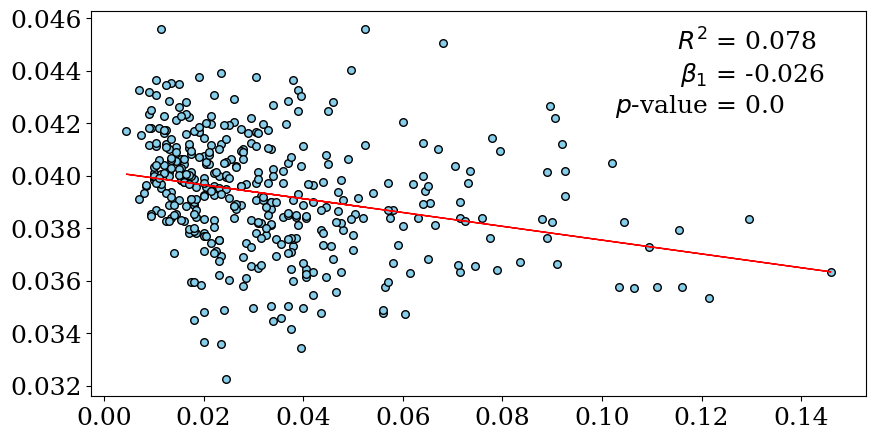

In [32]:
# Wage Phillips Curve: relationship between inflation and unemployment rate
wpc_model = sm.OLS(macro['wage_inflation'], sm.add_constant(macro['unemployment_rate']))
wpc_results = wpc_model.fit()
print(wpc_results.summary())
# plot results
plt.figure(figsize=(10,5))
plt.scatter(x=macro['unemployment_rate'], y=macro['wage_inflation'], color='skyblue', s=30, edgecolors='k')
plt.plot(macro['unemployment_rate'], wpc_results.params['const'] + wpc_results.params['unemployment_rate']*macro['unemployment_rate'], color='r', linewidth=1)
# regression results
plt.text(0.115, 0.0448, r'$R^2$ = ' + str(round(wpc_results.rsquared, 3)), fontsize=large)
plt.text(0.1157, 0.0436, r'$\beta_1$ = ' + str(round(wpc_results.params['unemployment_rate'], 3)), fontsize=large)
plt.text(0.10265, 0.0424, r'$p$-value = ' + str(round(wpc_results.pvalues['unemployment_rate'], 3)), fontsize=large)
# ticks
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\phillips_curve_wage.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:           profit_share   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     117.3
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           3.98e-24
Time:                        22:43:25   Log-Likelihood:                 1142.1
No. Observations:                 400   AIC:                            -2280.
Df Residuals:                     398   BIC:                            -2272.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8912      0.00

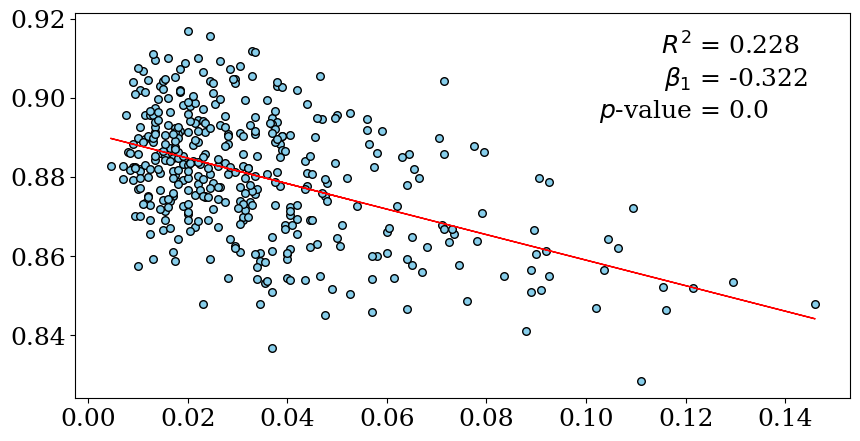

In [33]:
# Profit Share Phillips Curve: relationship between 1 - profit share and unemployment rate
pps_model = sm.OLS(1 - macro['profit_share'], sm.add_constant(macro['unemployment_rate']))
pps_results = pps_model.fit()
print(pps_results.summary())
# plot results
plt.figure(figsize=(10,5))
plt.scatter(x=macro['unemployment_rate'], y=1 - macro['profit_share'], color='skyblue', s=30, edgecolors='k')
plt.plot(macro['unemployment_rate'], pps_results.params['const'] + pps_results.params['unemployment_rate']*macro['unemployment_rate'], color='r', linewidth=1)
# regression results
plt.text(0.115, 0.911, r'$R^2$ = ' + str(round(pps_results.rsquared, 3)), fontsize=large)
plt.text(0.1157, 0.903, r'$\beta_1$ = ' + str(round(pps_results.params['unemployment_rate'], 3)), fontsize=large)
plt.text(0.10265, 0.895, r'$p$-value = ' + str(round(pps_results.pvalues['unemployment_rate'], 3)), fontsize=large)
# ticks
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\phillips_curve_shaikh.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:            rgdp_growth   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     3071.
Date:                Tue, 30 Apr 2024   Prob (F-statistic):          3.26e-189
Time:                        22:43:29   Log-Likelihood:                 1402.6
No. Observations:                 400   AIC:                            -2801.
Df Residuals:                     398   BIC:                            -2793.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0217    

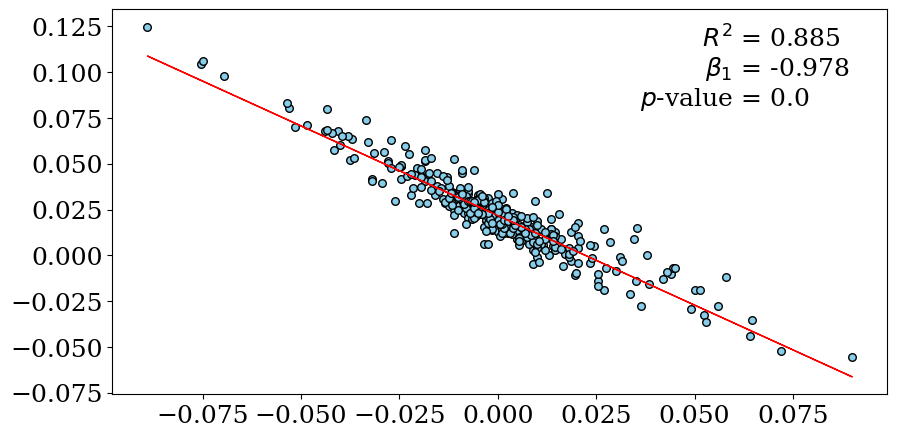

In [34]:
# Oken Curve: relationship between the change in unemployment rate and real GDP growth rate
oc_model = sm.OLS(macro['rgdp_growth'], sm.add_constant(macro['change_unemployment']))
oc_results = oc_model.fit()
print(oc_results.summary())
# plot results
plt.figure(figsize=(10,5))
plt.scatter(x=macro['change_unemployment'], y=macro['rgdp_growth'], color='skyblue', s=30, edgecolors='k')
plt.plot(macro['change_unemployment'], oc_results.params['const'] + oc_results.params['change_unemployment']*macro['change_unemployment'], color='r', linewidth=1)
# regression results
plt.text(0.052, 0.114, r'$R^2$ = ' + str(round(oc_results.rsquared, 3)), fontsize=large)
plt.text(0.0526, 0.098, r'$\beta_1$ = ' + str(round(oc_results.params['change_unemployment'], 3)), fontsize=large)
plt.text(0.0362, 0.082, r'$p$-value = ' + str(round(oc_results.pvalues['change_unemployment'], 3)), fontsize=large)
# ticks
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\okun_curve.png', bbox_inches='tight')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                 credit   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     291.2
Date:                Tue, 30 Apr 2024   Prob (F-statistic):           2.14e-49
Time:                        22:43:30   Log-Likelihood:                 447.49
No. Observations:                 400   AIC:                            -891.0
Df Residuals:                     398   BIC:                            -883.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1416      0.00

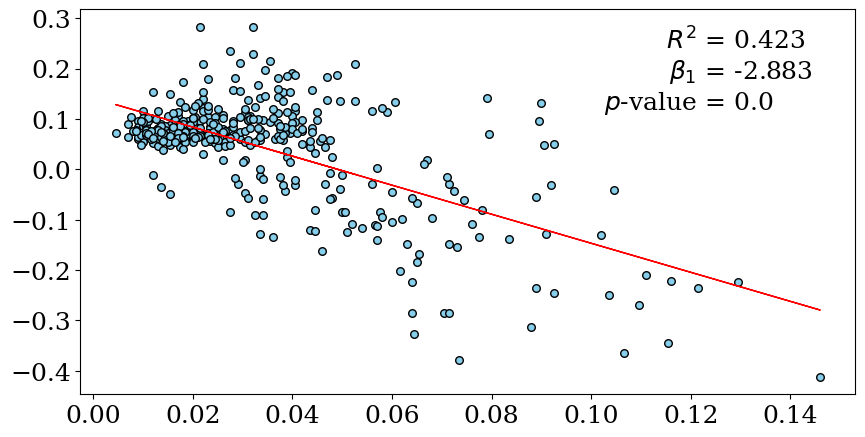

In [35]:
# Keen Curve: relationship between credit and unemployment rate
bc_model = sm.OLS(macro['credit'], sm.add_constant(macro['unemployment_rate']))
bc_results = bc_model.fit()
print(bc_results.summary())
# plot results
plt.figure(figsize=(10,5))
plt.scatter(x=macro['unemployment_rate'], y=macro['credit'], color='skyblue', s=30, edgecolors='k')
plt.plot(macro['unemployment_rate'], bc_results.params['const'] + bc_results.params['unemployment_rate']*macro['unemployment_rate'], color='r', linewidth=1)
# regression results
plt.text(0.115, 0.24, r'$R^2$ = ' + str(round(bc_results.rsquared, 3)), fontsize=large)
plt.text(0.1157, 0.18, r'$\beta_1$ = ' + str(round(bc_results.params['unemployment_rate'], 3)), fontsize=large)
plt.text(0.10265, 0.12, r'$p$-value = ' + str(round(bc_results.pvalues['unemployment_rate'], 3)), fontsize=large)
# ticks
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\keen_curve.png', bbox_inches='tight')
plt.show()

# Batch Simulations

## Macro: Real GDP Growth Rate

In [36]:
# cfirm growth rates distribution
real_gdp = pd.read_sql_query(
    f"""
        SELECT 
            simulation, 
            time, 
            real_gdp
        FROM 
            macro_data
    ;
    """,
    con
)
# real gdp growth rate
real_gdp['growth'] = np.log(real_gdp['real_gdp']) - np.log(real_gdp['real_gdp'].shift(steps))
# remove transient data
real_gdp = real_gdp.loc[real_gdp['time'] >= start]
real_gdp

,simulation,time,real_gdp,growth
199,0,200,5547.977096,0.026681
200,0,201,5608.776068,0.015116
201,0,202,5625.511362,0.052150
202,0,203,5705.541278,0.033065
203,0,204,5755.031685,0.036641
...,...,...,...,...
29995,49,596,51206.118372,0.007568
29996,49,597,50887.372916,-0.005499
29997,49,598,51761.270317,0.003714
29998,49,599,52135.404038,0.011779


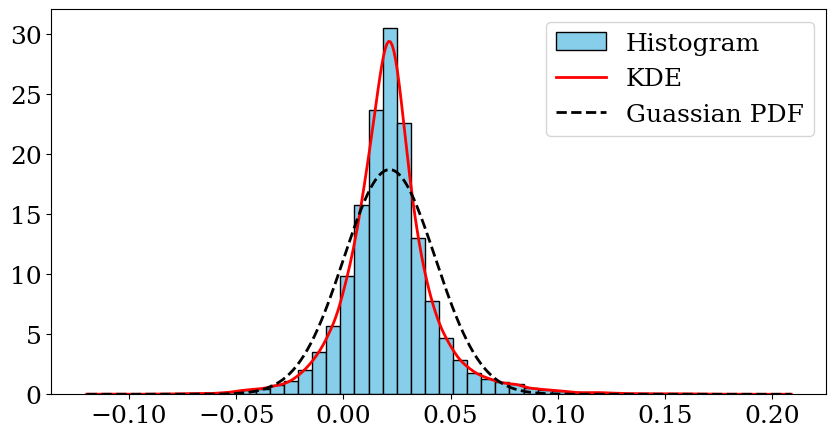

Real GDP Growth Mean =  0.02155287397335525
Real GDP Growth Standard Deviation 0.021325997140703764


In [37]:
# Real GDP growth rates distribution
plt.figure(figsize=(x_figsize,y_figsize))
plt.hist(real_gdp['growth'], bins=50, color='skyblue', edgecolor="black", density=True, label='Histogram')
# KDE
kernel = stats.gaussian_kde(real_gdp['growth'])
x = np.linspace(real_gdp['growth'].min(), real_gdp['growth'].max(), 400)
plt.plot(x, kernel.evaluate(x), color='r', linewidth=2, label='KDE')
# Gaussian fit
mu, sigma = stats.norm.fit(real_gdp['growth'])
pdf = stats.norm.pdf(x, mu, sigma)
plt.plot(x, pdf, color='k', linestyle='--', linewidth=2, label='Guassian PDF')
# ticks
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
# legend
plt.legend(loc='upper right', fontsize=large)
# save figure
plt.savefig(f'{figure_path}\\dist_rgdp_growth.png', bbox_inches='tight')
plt.show()
print('Real GDP Growth Mean = ', mu)
print('Real GDP Growth Standard Deviation', sigma)

In [38]:
# Kolmogorov-Smirnov Test for Nomaliy
significance = 0.01
ks_result = stats.kstest(real_gdp['growth'], 'norm')
# print test outcome
if ks_result.pvalue < significance:
    print(f"Accept null hypothesis, therefore distribution of growth rates is not normally distributed ({significance*100}% significance level)")
else:
    print(f"Reject null hypothesis, therefore distribution of growth rates is normally distributed ({significance*100}% significance level)")
# print results
print(ks_result)

Accept null hypothesis, therefore distribution of growth rates is not normally distributed (1.0% significance level)
KstestResult(statistic=0.47784046556261345, pvalue=0.0, statistic_location=-0.04205607221767238, statistic_sign=-1)


Calculating best minimal value for power law fit


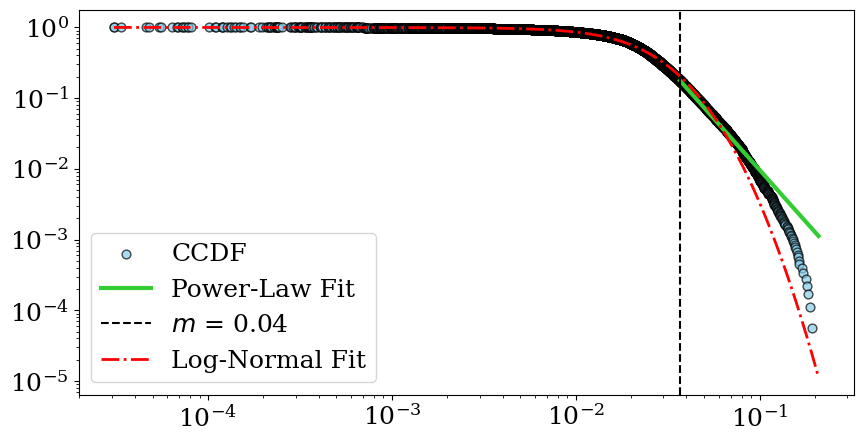

Power law exponent = 3.9157616198578755
Power law minimum = 0.03688644078494008
Distribution compare = (-27.42285891804498, 3.820259637528369e-06)

Calculating best minimal value for power law fit


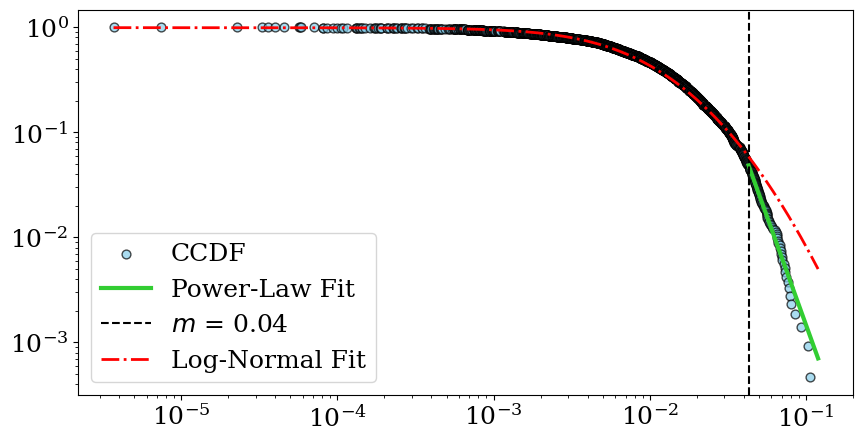

Power law exponent = 5.127102413920417
Power law minimum = 0.04296179334419037
Distribution compare = (-0.7117193566688732, 0.44258632075110427)



In [39]:
# CCDF distribution of positive real GDP growth rates
plot_ccdf(real_gdp['growth'].loc[real_gdp['growth'] > 0], figsize=(x_figsize,y_figsize), fontsize=large, savefig=f'{figure_path}\\ccdf_rgdp_growth_pos.png', dp=2)
# CCDF distribution of negative real GDP growth rates
plot_ccdf(np.abs(real_gdp['growth'].loc[real_gdp['growth'] < 0]), figsize=(x_figsize,y_figsize), fontsize=large, savefig=f'{figure_path}\\ccdf_rgdp_growth_neg.png', dp=2)

## Micro 

### Consumption Firms

In [40]:
cfirms = pd.read_sql_query(
    f"""
        SELECT 
            simulation,
            time,
            id,
            output,
            capital,
            debt
        FROM 
            firm_data
        WHERE 
            firm_type = 'ConsumptionFirm' and time = {middle}
    ;
    """,
    con
)
cfirms

,simulation,time,id,output,capital,debt
0,0,300,Cfirm: 4,75.398587,395.238120,331.278656
1,0,300,Cfirm: 6,119.271571,361.635646,929.763326
2,0,300,Cfirm: 7,53.239103,483.031874,191.189960
3,0,300,Cfirm: 17,49.255314,775.775736,243.105270
4,0,300,Cfirm: 18,40.496987,175.021082,341.302925
...,...,...,...,...,...,...
9866,49,300,Cfirm: 54390,8.207572,116.611818,0.000000
9867,49,300,Cfirm: 54391,4.721883,616.162465,0.000000
9868,49,300,Cfirm: 54392,7.769751,530.114503,0.000000
9869,49,300,Cfirm: 54393,6.702412,634.853193,0.000000


Calculating best minimal value for power law fit


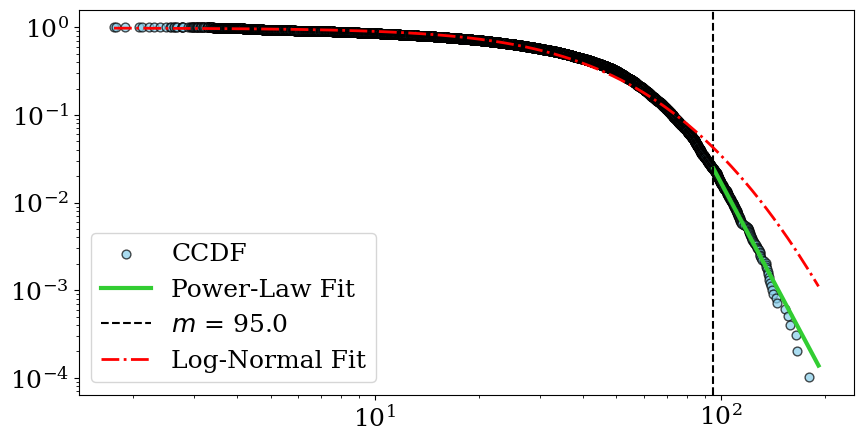

Power law exponent = 8.398596765145292
Power law minimum = 95.34963467584507
Distribution compare = (-0.453561896679775, 0.5599979991468682)

Calculating best minimal value for power law fit


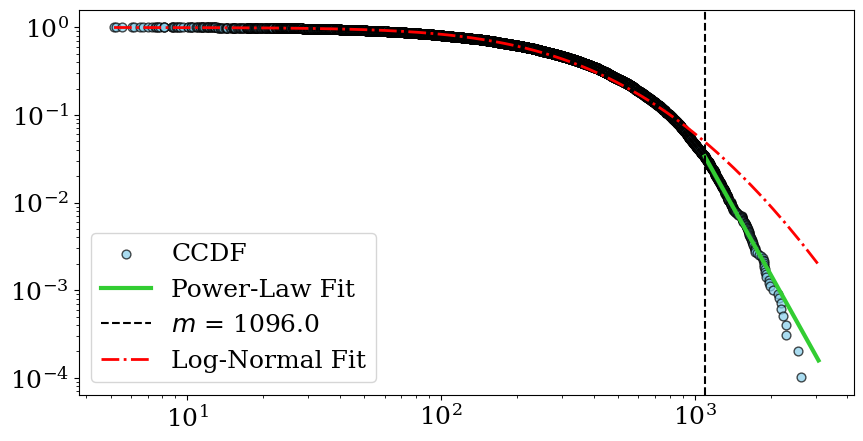

Power law exponent = 6.195669338832515
Power law minimum = 1096.229673118111
Distribution compare = (-1.0104963459728884, 0.3834295918954226)

Calculating best minimal value for power law fit


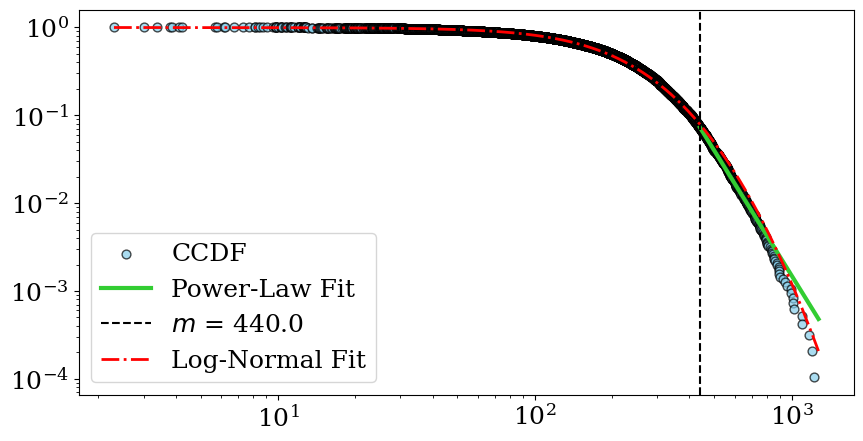

Power law exponent = 5.720610140878622
Power law minimum = 439.60132174791113
Distribution compare = (-3.60518938348134, 0.1026390189476335)



In [41]:
# CCDF distribution of cfirms output
plot_ccdf(cfirms['output'], figsize=(x_figsize,y_figsize), fontsize=large, savefig=f'{figure_path}\\ccdf_cfirms_output.png')
# CCDF distribution of cfirms capital
plot_ccdf(cfirms['capital'], figsize=(x_figsize,y_figsize), fontsize=large, savefig=f'{figure_path}\\ccdf_cfirms_capital.png')
# CCDF distribution of cfirms debt
plot_ccdf(cfirms['debt'].loc[cfirms['debt'] > 1], figsize=(x_figsize,y_figsize), fontsize=large, savefig=f'{figure_path}\\ccdf_cfirms_debt.png')

### Capital Firms

In [42]:
kfirms = pd.read_sql_query(
    f"""
        SELECT 
            simulation,
            time,
            id,
            output,
            debt
        FROM 
            firm_data
        WHERE 
            firm_type = 'CapitalFirm' and time = {middle}
    ;
    """,
    con
)
kfirms

,simulation,time,id,output,debt
0,0,300,Kfirm: 12,220.903435,8.841886e-15
1,0,300,Kfirm: 13,86.604729,4.138417e+02
2,0,300,Kfirm: 18,7.307925,4.940492e-15
3,0,300,Kfirm: 21,46.463582,4.075439e+02
4,0,300,Kfirm: 29,218.851907,2.541370e-14
...,...,...,...,...,...
2476,49,300,Kfirm: 9847,21.135971,0.000000e+00
2477,49,300,Kfirm: 9848,5.718052,0.000000e+00
2478,49,300,Kfirm: 9849,7.343449,0.000000e+00
2479,49,300,Kfirm: 9850,5.541839,0.000000e+00


Calculating best minimal value for power law fit


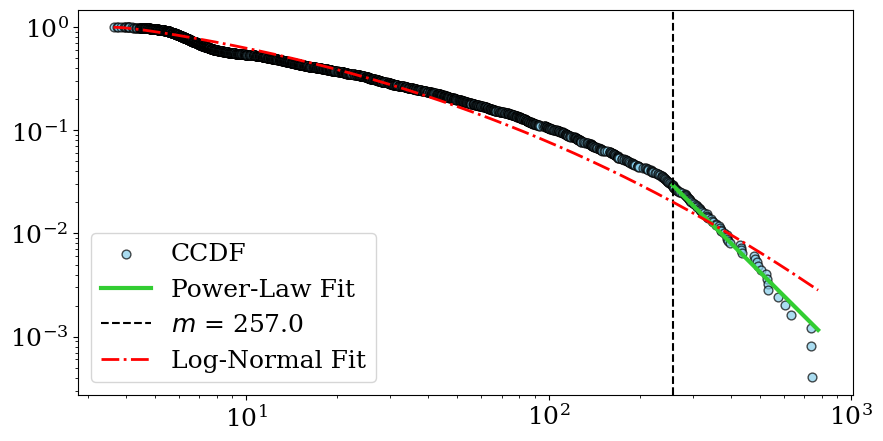

Power law exponent = 3.921384037504866
Power law minimum = 256.9507676442831
Distribution compare = (-1.1757968066123823, 0.305098271316143)

Calculating best minimal value for power law fit


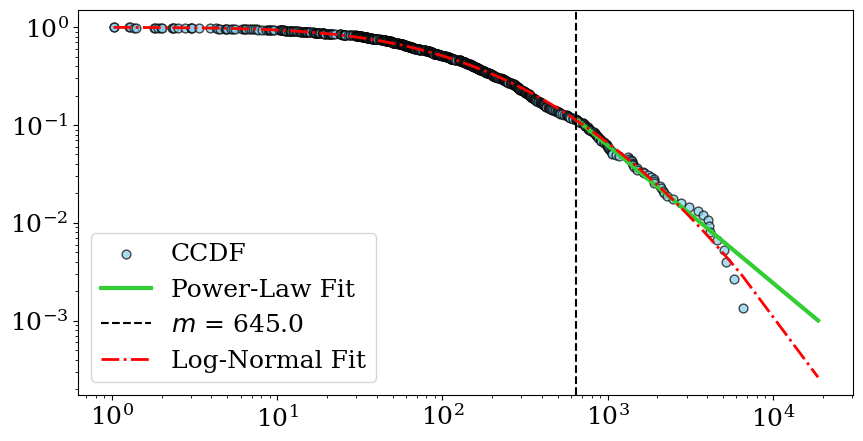

Power law exponent = 2.4066025463487657
Power law minimum = 645.1550842341508
Distribution compare = (-0.21645754376753157, 0.6778109003510904)



In [46]:
# CCDF distribution of kfirms output
plot_ccdf(kfirms['output'], figsize=(x_figsize,y_figsize), fontsize=large, savefig=f'{figure_path}\\ccdf_kfirms_output.png')
# CCDF distribution of kfirms debt
plot_ccdf(kfirms['debt'].loc[kfirms['debt'] > 1], figsize=(x_figsize,y_figsize), fontsize=large, savefig=f'{figure_path}\\ccdf_kfirms_debt.png')

### Banks

In [44]:
banks = pd.read_sql_query(
    f"""
        SELECT 
            simulation,
            time,
            id,
            loan_interest,
            loans
        FROM 
            bank_data
        WHERE 
            time = {middle}
    ;
    """,
    con
)
banks

,simulation,time,id,loan_interest,loans
0,0,300,Bank: 0,0.013647,2727.359598
1,0,300,Bank: 1,0.013319,4053.332988
2,0,300,Bank: 2,0.013881,14680.595542
3,0,300,Bank: 3,0.012265,67.271602
4,0,300,Bank: 4,0.013472,4857.771195
...,...,...,...,...,...
495,49,300,Bank: 5,0.013762,35.290606
496,49,300,Bank: 6,0.014285,21408.712718
497,49,300,Bank: 7,0.014758,8008.230857
498,49,300,Bank: 8,0.014074,9.576904


Calculating best minimal value for power law fit


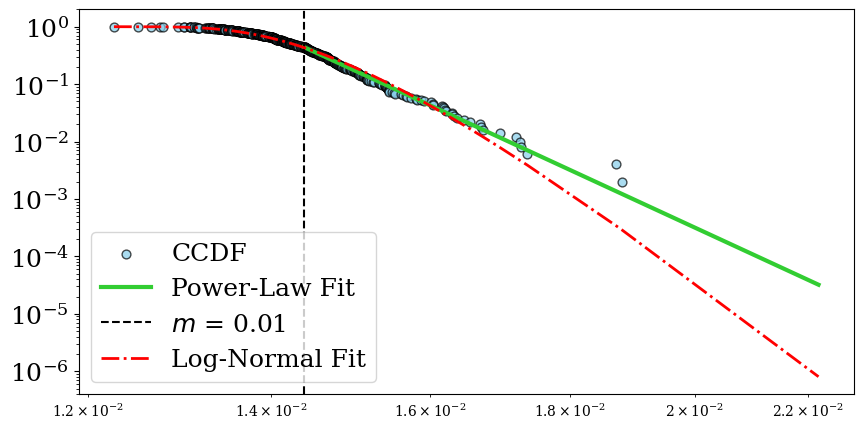

Power law exponent = 22.991220852573516
Power law minimum = 0.014388806503486055
Distribution compare = (-0.4386473441561689, 0.06377903893060054)

Calculating best minimal value for power law fit


C:\Users\Dylan\AppData\Roaming\Python\Python311\site-packages\powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


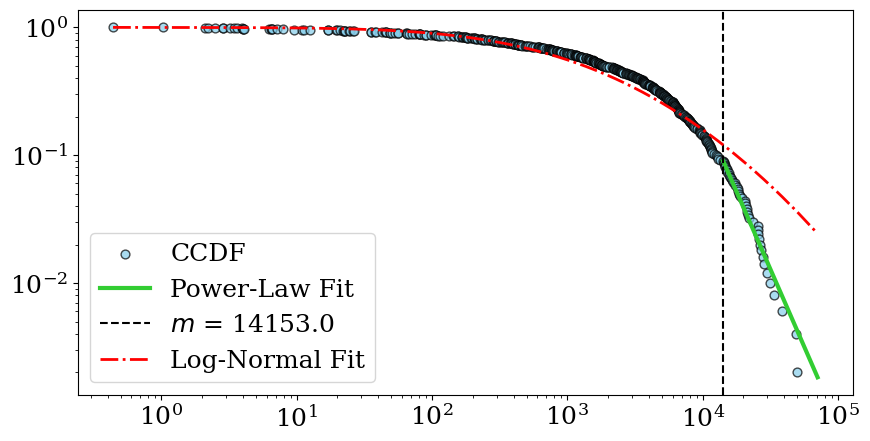

Power law exponent = 3.4238890720692408
Power law minimum = 14152.917217734295
Distribution compare = (-0.4444418485435282, 0.5639019599870544)



In [45]:
# CCDF distribution of banks loan interest rates
plot_ccdf(banks['loan_interest'], figsize=(x_figsize,y_figsize), fontsize=large, savefig=f'{figure_path}\\ccdf_banks_interest.png', dp=2)
# CCDF distribution of banks loan size
plot_ccdf(banks['loans'], figsize=(x_figsize,y_figsize), fontsize=large, savefig=f'{figure_path}\\ccdf_banks_loan.png')